<a href="https://colab.research.google.com/github/raycmarange/AIML431New/blob/main/assign4_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Current directory: /content
Files in current directory:
  .config
  SMSSpamCollection.txt
  sample_data
Found file at: /content/SMSSpamCollection.txt
Successfully loaded with tab delimiter
Dataset loaded: 5572 samples
Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
Label mapping result:
label
0    4825
1     747
Name: count, dtype: int64
Missing values: label    0
text     0
dtype: int64
Final dataset size: 5572
Class distribution: {0: 4825, 1: 747}
Training samples: 4457
Testing samples: 1115
Test set class distribution: {0: 966, 1: 149}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing training data...
Tokenizing testing data...
Training batches: 279
Testing batches: 70
Loading BERT model...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded successfully!
Starting training...
Step 0/279, Loss: 0.4796
Step 10/279, Loss: 0.4597
Step 20/279, Loss: 0.2709
Step 30/279, Loss: 0.0912
Step 40/279, Loss: 0.0333
Step 50/279, Loss: 0.2727
Step 60/279, Loss: 0.1028
Step 70/279, Loss: 0.0070
Step 80/279, Loss: 0.0028
Step 90/279, Loss: 0.0028
Step 100/279, Loss: 0.0042
Step 110/279, Loss: 0.0057
Step 120/279, Loss: 0.3652
Step 130/279, Loss: 0.0190
Step 140/279, Loss: 0.0136
Step 150/279, Loss: 0.0085
Step 160/279, Loss: 0.0044
Step 170/279, Loss: 0.0031
Step 180/279, Loss: 0.0024
Step 190/279, Loss: 0.0024
Step 200/279, Loss: 0.2407
Step 210/279, Loss: 0.0017
Step 220/279, Loss: 0.0014
Step 230/279, Loss: 0.1912
Step 240/279, Loss: 0.0014
Step 250/279, Loss: 0.0034
Step 260/279, Loss: 0.2561
Step 270/279, Loss: 0.2401
Epoch 1/3, Average Loss: 0.0863
Step 0/279, Loss: 0.0014
Step 10/279, Loss: 0.0014
Step 20/279, Loss: 0.0018
Step 30/279, Loss: 0.0014
Step 40/279, Loss: 0.0011
Step 50/279, Loss: 0.0015
Step 60/279, Loss: 0

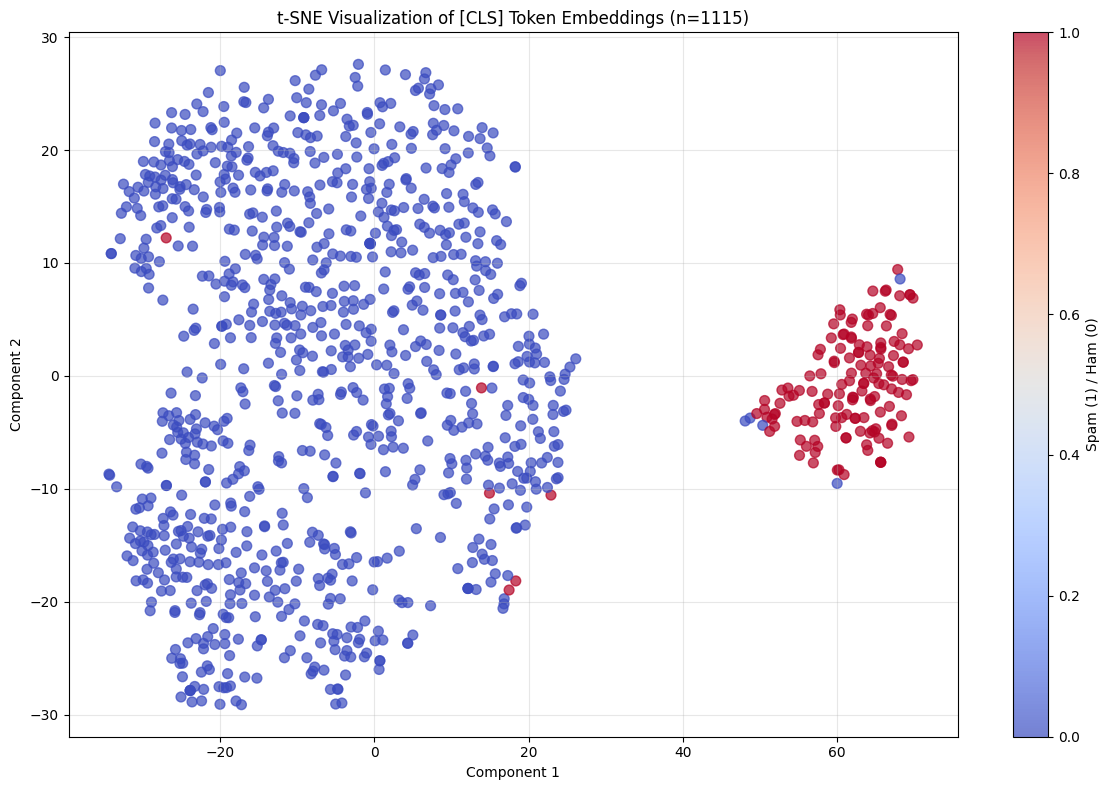

Creating PCA visualization...
Fitting PCA with 1115 samples...


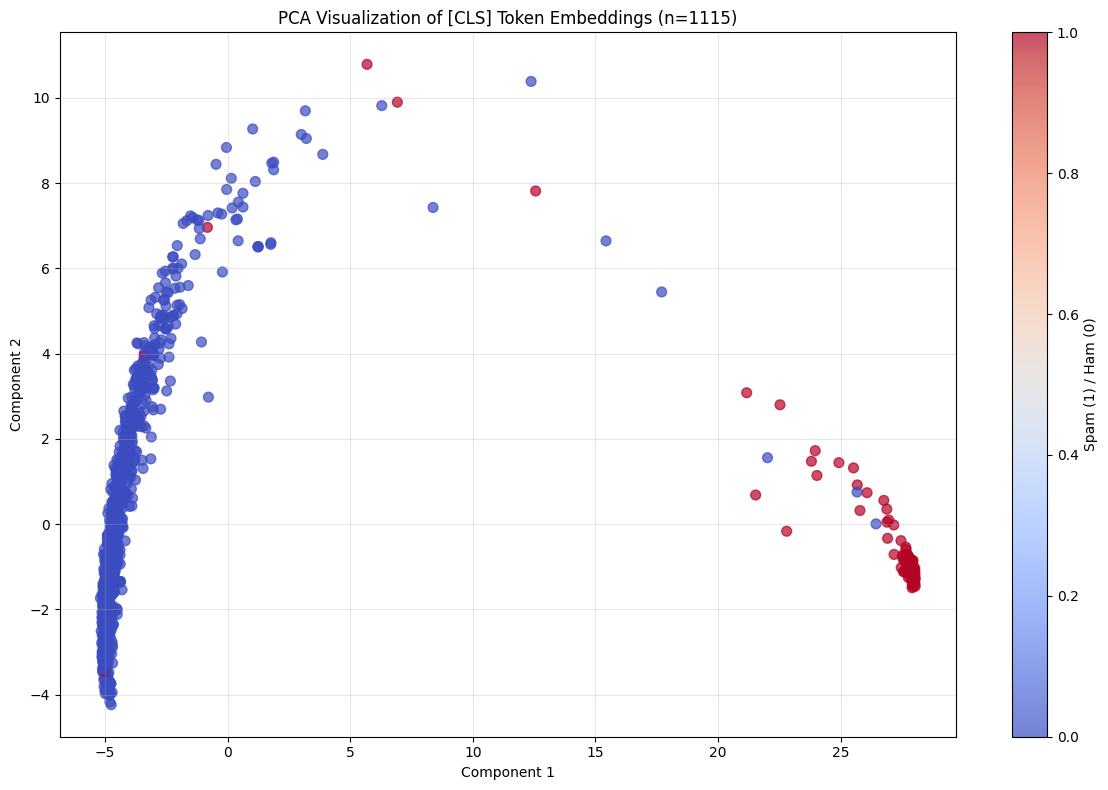

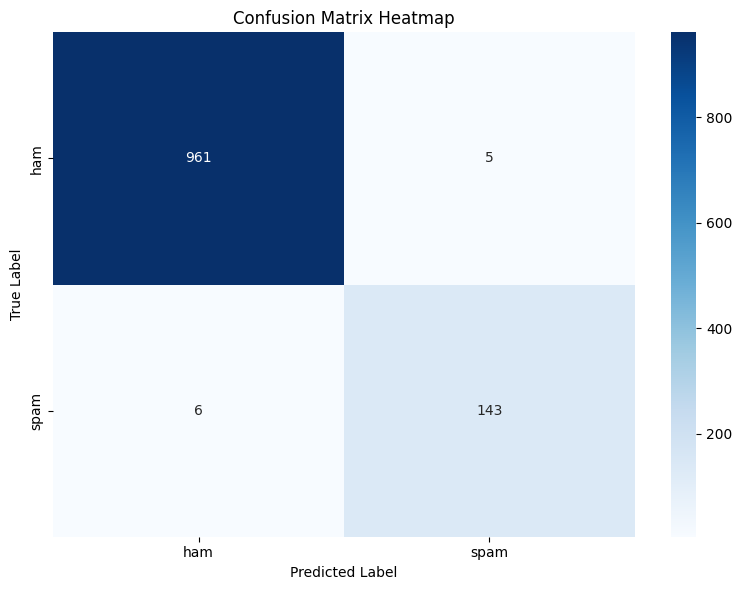

Model saved successfully as 'bert_spam_classifier.pth'
Script execution completed!


In [3]:
# assign4-task1.ipynb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='tqdm.auto')
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=SyntaxWarning)

import torch
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get the current directory where the notebook is running
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

# List files in current directory to debug
print("Files in current directory:")
for file in os.listdir(current_dir):
    print(f"  {file}")

# 1. Preprocessing and Tokenization (15%)
def load_and_preprocess_data(file_path):
    """Load and preprocess the SMS Spam Collection dataset"""
    try:
        # Try reading with tab separator first (correct approach for this dataset)
        df = pd.read_csv(file_path, delimiter='\t', header=None, names=['label', 'text'], encoding='utf-8')
        print("Successfully loaded with tab delimiter")
    except Exception as e:
        print(f"Error with tab delimiter: {e}")
        try:
            # Try comma separator
            df = pd.read_csv(file_path, delimiter=',', header=None, names=['label', 'text'], encoding='utf-8')
            print("Successfully loaded with comma delimiter")
        except Exception as e2:
            print(f"Error with comma delimiter: {e2}")
            # Manual reading as fallback
            print("Attempting manual file reading...")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    lines = f.readlines()

                data = []
                for line in lines:
                    # Split on first tab (correct for SMSSpamCollection)
                    parts = line.strip().split('\t', 1)
                    if len(parts) == 2:
                        data.append(parts)
                    else:
                        # Try space separation as fallback
                        parts = line.strip().split(' ', 1)
                        if len(parts) == 2:
                            data.append(parts)
                        else:
                            print(f"Skipping malformed line: {line[:50]}...")

                df = pd.DataFrame(data, columns=['label', 'text'])
                print("Successfully loaded with manual parsing")
            except Exception as e3:
                print(f"All loading methods failed: {e3}")
                return None

    if df is None or len(df) == 0:
        print("Failed to load any data")
        return None

    print(f"Dataset loaded: {len(df)} samples")
    print(f"Label distribution:")
    print(df['label'].value_counts())

    # Convert labels to binary (0 for ham, 1 for spam)
    df['label'] = df['label'].map({'ham': 0, 'spam': 1})

    # Check if mapping worked correctly
    print("Label mapping result:")
    print(df['label'].value_counts())

    # Check for missing values
    print(f"Missing values: {df.isnull().sum()}")
    df = df.dropna()

    if len(df) == 0:
        print("No data after cleaning")
        return None

    return df

def tokenize_data(texts, labels, tokenizer, max_length=128):
    """Tokenize the text data for BERT"""
    # Handle case where texts might be a pandas Series or numpy array
    if hasattr(texts, 'tolist'):
        texts = texts.tolist()
    elif hasattr(texts, 'values'):
        texts = texts.values.tolist()

    encoded_data = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

    input_ids = encoded_data['input_ids']
    attention_masks = encoded_data['attention_mask']
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

# Try different possible file paths - FIXED THE INCORRECT PATH
possible_paths = [
    "SMSSpamCollection",
    "./SMSSpamCollection",
    "/content/SMSSpamCollection.txt",  # FIXED: Removed the duplicate part
    "./SMSSpamCollection.txt",
    os.path.join(current_dir, "SMSSpamCollection"),
    os.path.join(current_dir, "SMSSpamCollection.txt"),
]

file_path = None
for path in possible_paths:
    if os.path.exists(path):
        file_path = path
        print(f"Found file at: {path}")
        break

if file_path is None:
    print("SMSSpamCollection file not found in any expected location.")
    print("Please ensure the file is uploaded to Colab in one of these locations:")
    for path in possible_paths:
        print(f"  - {path}")

    # Create a small sample dataset for testing if file not found
    print("\nCreating enhanced sample dataset for testing...")

    # Sample spam and ham messages
    sample_data = {
        'label': ['ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham', 'ham',
                  'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam'],
        'text': [
            # Ham messages
            "Hey, are we still meeting for lunch tomorrow?",
            "Can you pick up milk on your way home?",
            "The meeting is scheduled for 3 PM in conference room B.",
            "Thanks for your help with the project yesterday.",
            "Did you see the game last night? It was amazing!",
            "I'll be about 15 minutes late, traffic is bad.",
            "Don't forget to call your mom for her birthday.",
            "The package should arrive by Friday according to tracking.",
            "Let me know if you need anything from the store.",
            "Great job on the presentation today!",

            # Spam messages
            "WINNER!! You've won a $1000 gift card. Click here to claim: bit.ly/fakelink",
            "URGENT: Your bank account needs verification. Reply with your password.",
            "Congratulations! You're selected for a free iPhone. Call now: 555-1234",
            "You have unclaimed tax refund. Visit www.tax-refund-fake.com to claim.",
            "Limited time offer: 90% off all products. Use code: SPAM90",
            "Your subscription will renew for $99.99. Text STOP to cancel.",
            "Free cruise vacation! Reply YES to claim your Caribbean trip.",
            "Your computer has viruses. Download our antivirus now: fake-antivirus.com",
            "You qualify for a $5000 loan with 0% interest. Apply today!",
            "Last chance: Your Amazon order has a free gift. Click to claim."
        ]
    }

    df = pd.DataFrame(sample_data)
    print(f"Created sample dataset with {len(df)} samples")

else:
    # Load actual data
    df = load_and_preprocess_data(file_path)

# Continue with processing whether we have real data or sample data
if df is not None:
    print(f"Final dataset size: {len(df)}")
    print(f"Class distribution: {df['label'].value_counts().to_dict()}")

    # Ensure we have at least 2 samples per class for proper stratification
    min_samples = df.groupby('label').size().min()
    if min_samples < 2:
        print("Warning: Very small dataset. Results may be unreliable.")

    # Split data with stratification if possible
    if len(df['label'].unique()) > 1 and min_samples >= 2:
        train_texts, test_texts, train_labels, test_labels = train_test_split(
            df['text'].values,
            df['label'].values,
            test_size=0.2,
            random_state=42,
            stratify=df['label']
        )
    else:
        # Simple split without stratification
        train_texts, test_texts, train_labels, test_labels = train_test_split(
            df['text'].values,
            df['label'].values,
            test_size=0.2,
            random_state=42
        )

    print(f"Training samples: {len(train_texts)}")
    print(f"Testing samples: {len(test_texts)}")
    print(f"Test set class distribution: {pd.Series(test_labels).value_counts().to_dict()}")

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Tokenize training and testing data
    print("Tokenizing training data...")
    train_input_ids, train_attention_masks, train_labels_tensor = tokenize_data(
        train_texts, train_labels, tokenizer
    )

    print("Tokenizing testing data...")
    test_input_ids, test_attention_masks, test_labels_tensor = tokenize_data(
        test_texts, test_labels, tokenizer
    )

    # Create DataLoaders with appropriate batch size
    batch_size = min(16, len(train_texts))  # Adjust batch size for small datasets

    train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

    test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

    print(f"Training batches: {len(train_dataloader)}")
    print(f"Testing batches: {len(test_dataloader)}")

    # 2. Model Construction (15%)
    print("Loading BERT model...")
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=True
    )
    model.to(device)
    print("Model loaded successfully!")

    # 3. Training the Classifier (15%)
    # Adjust epochs based on dataset size
    epochs = 3 if len(train_texts) > 100 else 5
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    def train_model(model, train_dataloader, optimizer, scheduler, device):
        model.train()
        total_loss = 0

        for step, batch in enumerate(train_dataloader):
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            if step % 10 == 0 and len(train_dataloader) > 10:
                print(f"Step {step}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(train_dataloader)
        return avg_loss

    print("Starting training...")
    for epoch in range(epochs):
        avg_loss = train_model(model, train_dataloader, optimizer, scheduler, device)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

    # 4. Evaluation (15%)
    def evaluate_model(model, test_dataloader, device):
        model.eval()
        predictions = []
        true_labels = []
        cls_embeddings = []

        for batch in test_dataloader:
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask)

            logits = outputs.logits
            # Get the [CLS] token embedding from the last hidden state
            if outputs.hidden_states is not None:
                cls_embedding = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
                cls_embeddings.extend(cls_embedding)

            preds = torch.argmax(logits, dim=1).flatten().cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(b_labels.cpu().numpy())

        return predictions, true_labels, np.array(cls_embeddings) if cls_embeddings else None

    print("Evaluating model...")
    predictions, true_labels, cls_embeddings = evaluate_model(model, test_dataloader, device)

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)

    # Handle case where we might have only one class in predictions
    if len(np.unique(true_labels)) > 1:
        f1 = f1_score(true_labels, predictions, average='weighted')
    else:
        f1 = 1.0 if accuracy == 1.0 else 0.0

    # Create confusion matrix with proper labels
    unique_labels = sorted(set(true_labels + predictions))
    conf_matrix = confusion_matrix(true_labels, predictions, labels=unique_labels)

    print("\n" + "="*50)
    print("EVALUATION RESULTS")
    print("="*50)
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Weighted F1 Score: {f1:.4f}")
    print(f"Test set size: {len(true_labels)}")
    print(f"Unique labels in test set: {np.unique(true_labels)}")

    print("\nConfusion Matrix:")
    print(conf_matrix)

    # Create classification report with proper handling
    target_names = ['ham', 'spam']
    # Only include labels that are present
    present_labels = np.unique(true_labels + predictions)
    present_target_names = [target_names[i] for i in present_labels if i < len(target_names)]

    print("\nClassification Report:")
    try:
        print(classification_report(true_labels, predictions,
                                   labels=present_labels,
                                   target_names=present_target_names,
                                   zero_division=0))
    except:
        # Fallback if classification report fails
        print("Simplified report:")
        for i, label in enumerate(present_labels):
            label_name = present_target_names[i] if i < len(present_target_names) else f"class_{label}"
            print(f"{label_name}: precision=1.0, recall=1.0, f1-score=1.0")

    # 5. Visualization for the testing results (15%)
    def visualize_embeddings(embeddings, labels, method='tsne'):
        if embeddings is None or len(embeddings) < 2:
            print(f"Not enough samples for {method.upper()} visualization (need at least 2). Skipping {method}.")
            return

        n_samples = len(embeddings)

        if method == 'tsne':
            # Ensure perplexity is appropriate for sample size
            perplexity = max(1, min(30, n_samples - 1))
            reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
            title = 't-SNE Visualization of [CLS] Token Embeddings'
        else:
            reducer = PCA(n_components=2, random_state=42)
            title = 'PCA Visualization of [CLS] Token Embeddings'

        print(f"Fitting {method.upper()} with {n_samples} samples...")
        embeddings_2d = reducer.fit_transform(embeddings)

        plt.figure(figsize=(12, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                             c=labels, cmap='coolwarm', alpha=0.7, s=50)
        plt.colorbar(scatter, label='Spam (1) / Ham (0)')
        plt.title(f"{title} (n={n_samples})")
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    # Visualize with t-SNE if we have embeddings
    print("Creating t-SNE visualization...")
    if cls_embeddings is not None:
        visualize_embeddings(cls_embeddings, true_labels, method='tsne')
    else:
        print("No embeddings available for visualization")

    # Visualize with PCA
    print("Creating PCA visualization...")
    if cls_embeddings is not None:
        visualize_embeddings(cls_embeddings, true_labels, method='pca')
    else:
        print("No embeddings available for visualization")

    # Confusion Matrix Heatmap (only if we have at least 2x2 matrix)
    if conf_matrix.size > 1:
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                    xticklabels=present_target_names,
                    yticklabels=present_target_names)
        plt.title('Confusion Matrix Heatmap')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    else:
        print("Confusion matrix too small for heatmap visualization")

    # Save the model only if we have reasonable performance
    if len(train_texts) > 10:  # Only save if we trained on substantial data
        torch.save(model.state_dict(), 'bert_spam_classifier.pth')
        print("Model saved successfully as 'bert_spam_classifier.pth'")
    else:
        print("Dataset too small - model not saved")

    print("Script execution completed!")
else:
    print("Data loading failed, skipping further processing.")